Initial solution: 14090.991680440771
Best objective: 16057.217925493062
For best solution, category one percentage is 0.33783783783783783


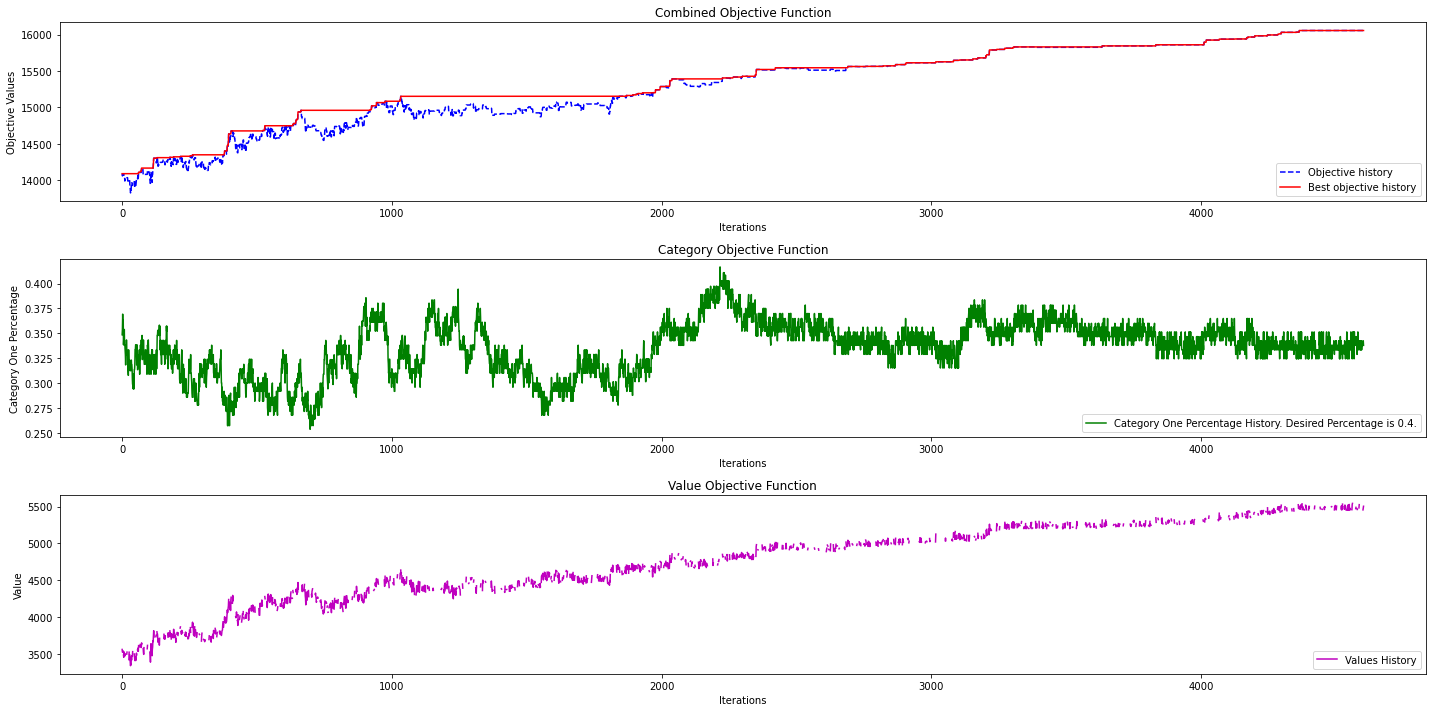

In [10]:
import numpy as np
import random
import matplotlib.pyplot as plt

amount_of_objects = 200

# 200 weights between 100-200
weights = np.random.randint(100,200, amount_of_objects)

# 200 values between 10-90 
values = np.random.randint(10,90, amount_of_objects)

# category 1 or 2, for 200 objects, with probability
categories = np.random.choice([1,2], size=amount_of_objects, p= [0.3, 0.7])
# categories chosen beforehand.
# can't choose which category wanna place item in
# all items are either in category 1 or 2

object_indices = range(amount_of_objects)
knapsack_capacity = 10000

# get categories measurement
def categories_objective_function(solution,category_one_desired_percentage):
    
    # dot product of solution and boolean value of categories[i]==1
    category_one = np.dot(solution,categories==1);
    
    # dot product of solution and boolean value of categories[i]==2
    category_two = np.dot(solution,categories==2);
    
    category_one_percentage = category_one/(category_one+category_two)
    category_two_percentage = 1- category_one_percentage
    
    # difference between gotten percentage and wanted percentage
    difference = category_one_percentage-category_one_desired_percentage
    
    abs_difference = np.square(difference)
    # can be infinite number of decimal places
    # can be any number between 0-1
    
    evaluation = 1 - abs_difference
    # always return positive
    
    return category_one_percentage, evaluation

# get values measurement
def value_objective_function(solution):
   
    total_weight = np.dot(solution,weights)
    
    if total_weight>knapsack_capacity:
        return float("-inf")
    
    return np.dot(solution,values)

# combine values measurement and categories measurement
def combined_objective_function(solution, category_weighting_factor, category_one_desired_percentage):
    
    value_evaluation = value_objective_function(solution)
    
    category_one_percentage, objf_cat_eval=categories_objective_function(solution,category_one_desired_percentage) 
    
    # chose this way so that: 
    # values and amount of objects can scale without affecting category eval
    # disjoint from value_objective_function
    # standardized for all solutions (as mean and amount of objects constant)
    category_evaluation = objf_cat_eval * amount_of_objects * np.mean(values) 
    
    total_evaluation = value_evaluation + category_weighting_factor*category_evaluation
    
    return value_evaluation, category_one_percentage, total_evaluation    
    
def get_neighbour(current_solution):
    
    chance_of_using_choice_1 = 0.6
    can_use_choice_2 = 0 in current_solution and 1 in current_solution
    if np.random.random() < chance_of_using_choice_1 or not can_use_choice_2:
        neighbourhood_func = neighbour_choice_1
    else:
        neighbourhood_func = neighbour_choice_2
        
    return neighbourhood_func(current_solution)

def neighbour_choice_1(current_solution):
    i = random.choice(object_indices)
    neighbour_solution = np.copy(current_solution)
    neighbour_solution[i] = 1 - neighbour_solution[i] 
    
    return neighbour_solution

def neighbour_choice_2(current_solution):
    used_i = 0
    used_j = 0
    while used_i == used_j:
        i = random.choice(object_indices)
        j = random.choice(object_indices)
        used_i = current_solution[i]
        used_j = current_solution[j]
        
    neighbour_solution = np.copy(current_solution)
    
    neighbour_solution[i] = 1 - neighbour_solution[i] #same as boolean flip
    neighbour_solution[j] = 1 - neighbour_solution[j] #same as boolean flip
    
    return neighbour_solution

def SA_knapsack(initial_temperature, cooling_rate, category_weighting_factor,category_one_desired_percentage): 

    # category evaluation
    category_history = []
    
    # value evaluation 
    value_history = []
    
    # items chosen
    solution_history = []
    
    # objective evaluated from combination of category and value 
    objective_history = []
    best_objective_history = []
    
    # initialize values for best objective and best solution
    best_objective = float("-inf")
    best_solution = None
    
    current_solution = random_initial_solution()
    value_evaluation, category_one_percentage, current_objective = combined_objective_function(current_solution,category_weighting_factor,category_one_desired_percentage)
    print(f'Initial solution: {current_objective}')

    best_solution = current_solution
    best_objective = current_objective

    def add_history(current_solution, current_objective, best_objective, category_one_percentage,value_evaluation):
        solution_history.append(current_solution)
        objective_history.append(current_objective)
        best_objective_history.append(best_objective)
        category_history.append(category_one_percentage)
        value_history.append(value_evaluation)
    
    add_history(current_solution, current_objective, best_objective,category_one_percentage,value_evaluation)
    
    current_temperature = initial_temperature
    
    while current_temperature > 1:
        
        # get new solution utilizing neighbour function
        new_solution = get_neighbour(current_solution)
        
        #category_one_percentage, current_objective = combined_objective_function(current_solution,category_weighting_factor,category_one_desired_percentage)
    
        
        # get objective value of that new solution utilizing objective function
        value_evaluation, category_one_percentage, objective_new_solution = combined_objective_function(new_solution, category_weighting_factor, 
                                                             category_one_desired_percentage)
        
        # calculate difference in objective values between current and new
        diff = objective_new_solution-current_objective
        
        # as time goes on
        # values will shift towards the left of the exponential curve
        # due to the x = diff/T becoming smaller
        # due to the diff becoming smaller
        # even though the divisor T becomes smaller
        if np.exp(diff/current_temperature) > np.random.rand():
            current_objective = objective_new_solution
            current_solution = new_solution
            if current_objective > best_objective:
                best_objective = current_objective
                best_solution = current_solution 
        
        # reduce temperature
        current_temperature *= (1-cooling_rate)
        #print(f"temp {current_temperature}, obj {current_objective}")
        
        add_history(current_solution, current_objective, best_objective,category_one_percentage,value_evaluation)
       
    print(f'Best objective: {best_objective}')
 
    return best_solution, solution_history, objective_history, best_objective_history, \
           category_history, value_history, category_one_desired_percentage


def random_initial_solution():
    total_weight = 0

    solution = np.zeros(amount_of_objects)
    # while the knapsack is not full
    # keep filling up knapsack with random objects
    for index in np.random.permutation(object_indices):
        if weights[index] <= knapsack_capacity - total_weight:
            solution[index] = 1
            total_weight += weights[index]
            
    return solution

# utilize simulated annealing function
best_solution, solution_history, objective_history, best_objective_history, \
category_history, value_history, category_one_desired_percentage = \
    SA_knapsack(initial_temperature=100, cooling_rate=0.001,
                category_weighting_factor=1, category_one_desired_percentage=0.4)

best_solution_cat_one_percentage = np.dot(best_solution,categories==1)/(np.dot(best_solution,categories==1) + np.dot(best_solution,categories==2))
print(f'For best solution, category one percentage is {best_solution_cat_one_percentage}')
#print(f'Total value is {np.dot(best_solution,weights)}')      

# plot values
fig, (ax1,ax2,ax3) = plt.subplots(3, figsize=(20,10))

ax1.plot(objective_history,"b--",label = "Objective history")
ax1.plot(best_objective_history,"r-",label = "Best objective history")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Objective Values")
ax1.legend(loc='lower right')
ax1.set_title("Combined Objective Function")

ax2.plot(category_history,"g-", label = f'Category One Percentage History. '
                                        f'Desired Percentage is {category_one_desired_percentage}.')
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Category One Percentage")
ax2.legend(loc = "lower right")
ax2.set_title("Category Objective Function")

ax3.plot(value_history,"m-", label = "Values History")
ax3.set_xlabel("Iterations")
ax3.set_ylabel("Value")
ax3.legend(loc = "lower right")
ax3.set_title("Value Objective Function")

fig.tight_layout()

